In [81]:
from matplotlib import pyplot as plt
import numpy as np
import random
from IPython import display

from gomoku import Gomoku
from gomoku_with_group_map import GomokuWithGroupMap
from hand_crafted_gomoku_model import HandCraftedGomokuModel
from monte_carlo_tree_search import MonteCarloTreeSearch
from parallel_monte_carlo_tree_search import ParallelMonteCarloTreeSearch

In [82]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
shape = (19,19)

# Example with decent hand crafted model

In [4]:
game = GomokuWithGroupMap(shape)
tree_search = MonteCarloTreeSearch(game, HandCraftedGomokuModel(), 2, 10)
results = []

Outcome: 1  Action: (11, 11)


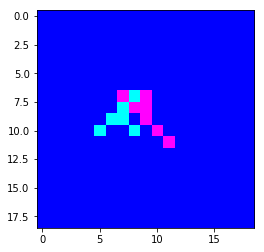

Game Over
Outcome: 0.005039957325745597  Action: (9, 9)
Outcome: 0.0017999980560025224  Action: (10, 8)
Outcome: 0.005849933267038512  Action: (7, 7)
Outcome: 0.00989967657967936  Action: (7, 8)
Outcome: 0.034995703089282036  Action: (8, 8)
Outcome: -0.012419361417906121  Action: (8, 7)
Outcome: 0.2192232513667264  Action: (10, 10)
Outcome: -0.18373938881917315  Action: (9, 6)
Outcome: 0.20288540386961826  Action: (7, 9)
Outcome: -0.1647156241449967  Action: (9, 7)
Outcome: 0.21527865742408853  Action: (8, 9)
Outcome: -0.024924836577914063  Action: (10, 5)
Outcome: 1  Action: (11, 11)


In [5]:
game.draw() 
plt.show()
for i in range(100):
    if game.game_over():
        print('Game Over')
        break
        
    result = tree_search.search()
    results.append(result)
    game.take_action(result['action'])
    
    display.clear_output(wait=True)
    print("Outcome: " + str(result['outcome']) + "  Action: " + str(result['action']))
    game.draw()    
    plt.show()

for r in results:
    print("Outcome: " + str(r['outcome']) + "  Action: " + str(r['action']))
    

# Model

In [6]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Activation, LeakyReLU, add
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam

Using TensorFlow backend.


In [7]:
def res_block(width,inp):
    x = Conv2D(width, (3,3), padding='same')(inp)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = add([x, inp])
    x = LeakyReLU(alpha=0.3)(x)
    return BatchNormalization(axis=3)(x)

In [8]:
def down_pooling_block(width,inp):
    x = Conv2D(width, (3,3), padding='same')(inp)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(2*width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(4*width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

In [9]:
hidden_layer_count = 512

input_state= Input(shape=(shape[0],shape[1],3))
x = Conv2D(hidden_layer_count, (7,7), padding='same', activation='relu')(input_state)
x = res_block(hidden_layer_count, x)
x = res_block(hidden_layer_count, x)
x = res_block(hidden_layer_count, x)

pmx = res_block(hidden_layer_count, x)
pmx = Conv2D(1, (1,1), padding='same')(pmx)
pmx = LeakyReLU(alpha=0.3)(pmx)
pmx = Flatten()(pmx)
prob_map = Activation('softmax', name='prob_map')(pmx)

#wx = down_pooling_block(hidden_layer_count, x)
wx = res_block(hidden_layer_count, x)
wx = GlobalAveragePooling2D()(wx)
wx = Dense(hidden_layer_count)(wx)
wx = LeakyReLU(alpha=0.3)(wx)
winner = Dense(1, activation='tanh', name='winner')(wx)


model = Model(input_state, [prob_map,winner])

model.compile(
    optimizer=Nadam(), 
    loss=['categorical_crossentropy','mean_squared_error'],
    loss_weights=[1, 2]
)

In [10]:
model.load_weights('/data/trained_models/gomoku_alpha_zero_resnet_weights_v4.h5')

# Pre train with hand crafted model

In [11]:
def action_to_onehot(action):
    result = np.zeros(shape)
    result[action] = 1
    return result

def board_augmentation(inp, out):
    sym = random.choice([' ','|','\\'])
    if sym == '|':
        inp = np.flip(inp,axis=0)
        out = np.flip(out,axis=0)
    elif sym =='\\':
        inp = np.transpose(inp, axes=(1,0,2))
        out = np.transpose(out)

    k = random.randint(0,3)
    return np.rot90(inp,k=k, axes=(0,1)), np.rot90(out,k=k, axes=(0,1))
    
        

In [ ]:
game = GomokuWithGroupMap(shape)
tree_search = MonteCarloTreeSearch(game, HandCraftedGomokuModel(), 2, 4)

In [ ]:
batch_size = 64

for batch_index in range(0):
    batch_input = []
    batch_move_pred = []
    batch_win_pred = []

    for i in range(batch_size):
        if game.game_over():
            game.reset()

        result = tree_search.search()

        board, action = board_augmentation(game.get_state_for_current_player(), action_to_onehot(result['action']))
        
        batch_input.append(board)
        batch_move_pred.append(action.flatten())
        batch_win_pred.append(result['outcome'])

        game.take_action(result['action'])

        #display.clear_output(wait=True)
        #print(str(i) + " Outcome: " + str(result['outcome']) + "  Action: " + str(result['action']))
        #game.draw()    
        #plt.show()

    losses = model.train_on_batch(np.array(batch_input), [np.array(batch_move_pred), np.array(batch_win_pred)])
    print(batch_index, losses, end="\r")

# Pre train from recorded games

In [ ]:
from os import listdir
from os.path import isfile, join
import math

In [ ]:
data_path = '/data/gomoku_alpha_zero/2_10'
data_files = [f for f in listdir(data_path) if isfile(join(data_path, f))]

In [ ]:
train_boards = []
train_scores = []
train_actions = []

base = np.ones(shape)
base[game.get_middle()] += 1

for file in data_files:
    with open(data_path+"/"+file, 'r') as f:
        board = np.stack((np.zeros(shape), np.zeros(shape),np.copy(base)), axis=2)
        player = 0
        for line in f.readlines():
            line = line.split(',')
            
            original = np.copy(board)
            action = action_to_onehot((int(line[1]), int(line[2])))
            
            original, action = board_augmentation(original, action)
            
            train_boards.append(original)
            train_scores.append(float(line[0]))
            train_actions.append(action.flatten())
            
            board[int(line[1]), int(line[2]), player] = 1
            player = 1 - player
            
            

In [ ]:
len(train_actions)

In [ ]:
model.fit(np.array(train_boards), [np.array(train_actions),np.array(train_scores)], shuffle=True, epochs=1, batch_size=128)

In [ ]:
#model.save('/data/trained_models/gomoku_alpha_zero_resnet_full_model_v4_1.h5')
#model.save_weights('/data/trained_models/gomoku_alpha_zero_resnet_weights_v4_1.h5')

# Reenforment learning

In [102]:
def choice2d(pmap, count = 10):
    shape = pmap.shape
    indices = np.transpose(np.indices(shape), axes=(1,2,0)).reshape((shape[0]*shape[1],2))
    choice_indices = np.random.choice(len(indices), count, p=pmap.reshape(shape[0]*shape[1]))
    return list(map(lambda x: tuple(x), indices[choice_indices].tolist()))

class LearnedGomokuModel:
    def __init__(self, model):
        self.model = model
    
    def get_predicted_outcomes(self, boards):
        pred = model.predict(boards)
        return pred[1].flatten()
    
    def get_probability_maps(self, boards):
        pred = model.predict(boards)
        shape = (boards.shape[0], boards.shape[1], boards.shape[2])
        return pred[0].reshape(shape)
        

In [103]:
game = Gomoku(shape)
lmodel = LearnedGomokuModel(model)
tree_search = ParallelMonteCarloTreeSearch(LearnedGomokuModel(model), 3, 3)
results = []

In [104]:
results

[]

Outcome: 1/0.637812  Action: (3, 8)


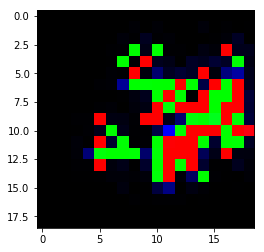

KeyboardInterrupt: 

In [105]:
while not game.game_over():
    outcomes, actions = tree_search.search([game])
    results.append({'outcome':outcomes[0], 'action':actions[0]})
    game.take_action(actions[0])
    predicted_outcome = lmodel.get_predicted_outcomes(np.array([game.get_state_for_current_player()]))
    
    display.clear_output(wait=True)
    print("Outcome: " + str(outcomes[0]) + "/" + str(predicted_outcome[0]) + "  Action: " + str(actions[0]))
    pmap = lmodel.get_probability_maps(np.array([game.get_state_for_current_player()]))
    board = game.get_state()
    plt.imshow(np.stack([board[:,:,0], board[:,:,1], pmap[0]/np.max(pmap[0])], axis = 2))
    plt.show()
    

for r in results:
    print("Outcome: " + str(r['outcome']) + "  Action: " + str(r['action']))
    

In [ ]:
lmodel = LearnedGomokuModel(model)
#lmodel = HandCraftedGomokuModel()
print(lmodel.predicted_outcome(game))
plt.imshow(lmodel.get_probability_map(game))